In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats import anova as sms_anova

#Changes
alpha = 0.05
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [8]:
#Importing the data from GitHub
churn_raw  = pd.read_csv("https://raw.githubusercontent.com/johnson80245/python/refs/heads/main/csvs/churn_raw_data.csv")
churn = churn_raw.copy()

In [9]:
#Renaming the columns to correct survey response
churn = churn.rename( columns = {
    "CaseOrder" : "case_order",
    "TimeZone" : "time_zone",
    "InternetService" : "internet_service",
    "OnlineSecurity" : "online_security",
    "OnlineBackup" : "online_backup",
    "DeviceProtection" : "device_protections",
    "TechSupport" : "tech_support", 
    "StreamingTV" : "streaming_tv", 
    "StreamingMovies" : "streaming_movies",
    "PaperlessBilling" : "paperless_billing",
    "PaymentMethod" : "payment_method",
    "MonthlyCharge" : "monthly_charge",
    "item1" : "timely_response",
    "item2" : "timely_fixes",
    'item3' : "timely_replacements",
    'item4' : "reliability",
    "item5" : "options",
    "item6" : "respectful_responses",
    "item7" : "courteous_exchange",
    "item8" : "evidence_of_active_listening"
})

In [10]:
#Cleaning column names:
def to_clean(val):
    return val.strip().lower().replace(" ","_")

churn = churn.rename(columns = to_clean)

In [11]:
#Changing mapping of true/false  & yes/no

bool_map = {'False': 0, 'True': 1, 'Yes':1,'No':0}
churn_map = {'Yes':1,'No':0}
bool_cols = ['techie', 'port_modem', 'tablet', 'phone', 'multiple',
           'online_security', 'online_backup', 'device_protections',
           'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing']

for column in bool_cols:
    churn[bool_cols] = churn[bool_cols].replace(bool_map)

churn[bool_cols] = churn[bool_cols].replace(bool_map)
churn['churn'] = churn['churn'].replace(bool_map)



C:\Users\Kyle\AppData\Local\Temp\ipykernel_10064\2120568355.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn[bool_cols] = churn[bool_cols].replace(bool_map)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_10064\2120568355.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn['churn'] = churn['churn'].replace(bool_map)


In [12]:
churn.churn.sample(5)

1500    0
9021    0
9785    0
3834    1
7546    0
Name: churn, dtype: int64

In [13]:
# How to handle outliers:

def fix_outliers_iqr(df, cols, method='cap'):
    for col in cols:
        #Setting IQR 
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        #Method types and how to handle outliers

        #Remove outliers
        if method == 'remove':
            df = df[(df[col] >= lower) & (df[col] <= upper)]
        #Cap at lower and upper IQE
        elif method == 'cap':
            df[col] = np.where(df[col] < lower, lower,
                        np.where(df[col] > upper, upper, df[col]))
        #Use the median to replace those outside the upper/lower
        elif method == 'median':
            median = df[col].median()
            df[col] = np.where((df[col] < lower) | (df[col] > upper), median, df[col])
        #Flag outliers for look 
        elif method == 'flag':
            df[f'{col}_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    return df



outlier_col = ['income','tenure','monthly_charge','bandwidth_gb_year']

churn = fix_outliers_iqr(churn,outlier_col,method = 'cap')


In [14]:
#### State stats



In [15]:
churn.head()

,case_order,customer_id,interaction,city,state,county,zip,lat,lng,population,area,timezone,job,children,age,education,employment,income,marital,gender,churn,outage_sec_perweek,email,contacts,yearly_equip_failure,...,contract,port_modem,tablet,internet_service,phone,multiple,online_security,online_backup,device_protections,tech_support,streaming_tv,streaming_movies,paperless_billing,payment_method,tenure,monthly_charge,bandwidth_gb_year,timely_response,timely_fixes,timely_replacements,reliability,options,respectful_responses,courteous_exchange,evidence_of_active_listening
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,38,Urban,America/Sitka,Environmental health practitioner,NaN,68.0,Master's Degree,Part Time,28561.99,Widowed,Male,0,6.972566,10,0,1,...,One year,1,1,Fiber Optic,1.0,0,1,1,0,0.0,0,1,1,Credit Card (automatic),6.795513,171.449762,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,10446,Urban,America/Detroit,"Programmer, multimedia",1.0,27.0,Regular High School Diploma,Retired,21704.77,Married,Female,1,12.014541,12,0,1,...,Month-to-month,0,1,Fiber Optic,1.0,1,1,0,0,0.0,1,1,1,Bank Transfer(automatic),1.156681,242.948015,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,3735,Urban,America/Los_Angeles,Chief Financial Officer,4.0,50.0,Regular High School Diploma,Student,NaN,Widowed,Female,0,10.245616,9,0,1,...,Two Year,1,0,DSL,1.0,1,0,0,0,0.0,0,1,1,Credit Card (automatic),15.754144,159.440398,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,Del Mar,CA,San Diego,92014,32.96687,-117.24798,13863,Suburban,America/Los_Angeles,Solicitor,1.0,48.0,Doctorate Degree,Retired,18925.23,Married,Male,0,15.206193,15,2,0,...,Two Year,0,0,DSL,1.0,0,1,0,0,0.0,1,0,1,Mailed Check,17.087227,120.249493,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,Needville,TX,Fort Bend,77461,29.38012,-95.80673,11352,Suburban,America/Chicago,Medical illustrator,0.0,83.0,Master's Degree,Student,40074.19,Separated,Male,1,8.960316,16,2,1,...,Month-to-month,1,0,Fiber Optic,0.0,0,0,0,0,1.0,1,0,0,Mailed Check,1.670972,150.761216,271.493436,4,4,4,3,4,4,4,5


In [16]:

#Age missing values:
# Using the median values by state

state_age_med = churn.groupby('state')['age'].median()
churn['age'] = churn.apply(lambda row: state_age_med[row['state']] if pd.isna(row['age']) and row['state'] in state_age_med else row['age'],axis=1)


#Create age group segments to apply to churn 
def segment_age_group(age):
    if pd.isna(age):
        return 'Unknown'
    if age < 18:
        return 'Under 18'
    if age <= 29:
        return '18-29'
    start = (age // 10) * 10
    end = start + 9
    return f"{int(start)}-{int(end)}"

churn['age_group'] = churn['age'].apply(segment_age_group)


# INCOME
income_medians = churn.groupby(['state', 'age_group'])['income'].median().to_dict()
income_overall_median = churn['income'].median()

churn['income'] = churn.apply(
    lambda row: income_medians.get((row['state'], row['age_group']))
    if pd.isna(row['income']) and not pd.isna(income_medians.get((row['state'], row['age_group'])))
    else income_overall_median if pd.isna(row['income'])
    else row['income'],
    axis=1
)


# CHILDREN
child_medians = churn.groupby(['state', 'age_group'])['children'].median().to_dict()
child_overall_median = churn['children'].median()

churn['children'] = churn.apply(
    lambda row: child_medians.get((row['state'], row['age_group']))
    if pd.isna(row['children']) and not pd.isna(child_medians.get((row['state'], row['age_group'])))
    else child_overall_median if pd.isna(row['children'])
    else row['children'],
    axis=1
)


# TECHIE
techie_medians = churn.groupby(['state', 'age_group'])['techie'].median().to_dict()
techie_overall_median = churn['techie'].median()

churn['techie'] = churn.apply(
    lambda row: techie_medians.get((row['state'], row['age_group']))
    if pd.isna(row['techie']) and not pd.isna(techie_medians.get((row['state'], row['age_group'])))
    else techie_overall_median if pd.isna(row['techie'])
    else row['techie'],
    axis=1
)


# INTERNET SERVICE (Categorical — uses mode by age_group)
internet_mode = churn.groupby('age_group')['internet_service'].agg(lambda x: x.mode().iloc[0]).to_dict()
internet_overall_mode = churn['internet_service'].mode().iloc[0]

churn['internet_service'] = churn.apply(
    lambda row: internet_mode.get(row['age_group'])
    if pd.isna(row['internet_service']) and row['age_group'] in internet_mode
    else internet_overall_mode if pd.isna(row['internet_service'])
    else row['internet_service'],
    axis=1
)


# PHONE
phone_medians = churn.groupby(['state', 'age_group'])['phone'].median().to_dict()
phone_overall_median = churn['phone'].median()

churn['phone'] = churn.apply(
    lambda row: phone_medians.get((row['state'], row['age_group']))
    if pd.isna(row['phone']) and not pd.isna(phone_medians.get((row['state'], row['age_group'])))
    else phone_overall_median if pd.isna(row['phone'])
    else row['phone'],
    axis=1
)


# TECH SUPPORT
tech_medians = churn.groupby(['state', 'age_group'])['tech_support'].median().to_dict()
tech_overall_median = churn['tech_support'].median()

churn['tech_support'] = churn.apply(
    lambda row: tech_medians.get((row['state'], row['age_group']))
    if pd.isna(row['tech_support']) and not pd.isna(tech_medians.get((row['state'], row['age_group'])))
    else tech_overall_median if pd.isna(row['tech_support'])
    else row['tech_support'],
    axis=1
)


# TENURE
tenure_medians = churn.groupby(['state', 'age_group'])['tenure'].median().to_dict()
tenure_overall_median = churn['tenure'].median()

churn['tenure'] = churn.apply(
    lambda row: tenure_medians.get((row['state'], row['age_group']))
    if pd.isna(row['tenure']) and not pd.isna(tenure_medians.get((row['state'], row['age_group'])))
    else tenure_overall_median if pd.isna(row['tenure'])
    else row['tenure'],
    axis=1
)


# BANDWIDTH_GB_YEAR
band_medians = churn.groupby(['state', 'age_group'])['bandwidth_gb_year'].median().to_dict()
band_overall_median = churn['bandwidth_gb_year'].median()

churn['bandwidth_gb_year'] = churn.apply(
    lambda row: band_medians.get((row['state'], row['age_group']))
    if pd.isna(row['bandwidth_gb_year']) and not pd.isna(band_medians.get((row['state'], row['age_group'])))
    else band_overall_median if pd.isna(row['bandwidth_gb_year'])
    else row['bandwidth_gb_year'],
    axis=1
)

In [17]:
churn = fix_outliers_iqr(churn,outlier_col,method = 'cap')

In [18]:
def univar(df,val):
  

    print("The Information Below is For:", val)
    
    plt.hist(df[val])
    plt.show()
    
    red_circle = dict(marker='o', markerfacecolor='red', markersize=6)
    mean_shape = dict(marker='D', markerfacecolor='blue', markersize=6)

    df[val].plot(kind='box',
                vert=False,
                flierprops=red_circle,
                showmeans=True,
                meanprops=mean_shape,
                notch=True)
    plt.show()
    
    print(df[val].describe().round(3))

    print("-------------------------------")
    print("The mode is:",df[val].mode()[0])
    
    print("____________________________________________")

In [19]:
#Cast as categorical data

cat_cols = ['case_order', 'customer_id', 'interaction', 'city', 'state', 'county',
            'area', 'timezone', 'job', 'education', 'employment',
            'marital', 'gender', 'churn', 'techie', 'contract',
            'port_modem', 'tablet', 'internet_service', 'phone', 'multiple',
            'online_security', 'online_backup', 'device_protections', 'tech_support', 'streaming_tv',
            'streaming_movies', 'paperless_billing', 'payment_method']

# 'timely_response', 'timely_fixes',
#             'timely_replacements', 'reliability', 'options', 'respectful_responses',
#             'courteous_exchange', 'evidence_of_active_listening'


for column in cat_cols:
    churn[column] = churn[column].astype('category')

In [20]:
#Describe all transformed
churn.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
case_order,10000.0,10000.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,10000,10000,A00088,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interaction,10000,10000,00089c35-8e66-4825-8a0e-dc266094e3a3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,10000,6058,Houston,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,10000,52,TX,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
county,10000,1620,Washington,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip,10000.0,NaN,NaN,NaN,49153.3196,27532.196108,601.0,26292.5,48869.5,71866.5,99929.0
lat,10000.0,NaN,NaN,NaN,38.757567,5.437389,17.96612,35.341828,39.3958,42.106908,70.64066
lng,10000.0,NaN,NaN,NaN,-90.782536,15.156142,-171.68815,-97.082812,-87.9188,-80.088745,-65.66785
population,10000.0,NaN,NaN,NaN,9756.5624,14432.698671,0.0,738.0,2910.5,13168.0,111850.0


In [21]:
#Fileds going to use:

churn = churn[['customer_id', 'state','area','children','age', 'education',
               'employment', 'income','marital','gender','churn',
               'outage_sec_perweek','yearly_equip_failure','contract','internet_service',
               'tech_support','streaming_tv','streaming_movies','tenure',
               'monthly_charge','bandwidth_gb_year', 'timely_response', 'timely_fixes',
               'timely_replacements','reliability','options','respectful_responses',
               'courteous_exchange','evidence_of_active_listening','age_group']]


The Information Below is For: age


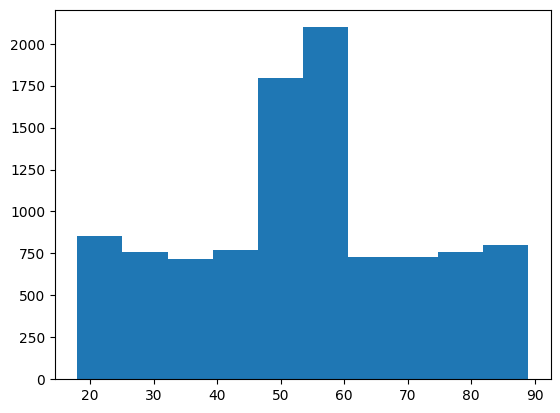

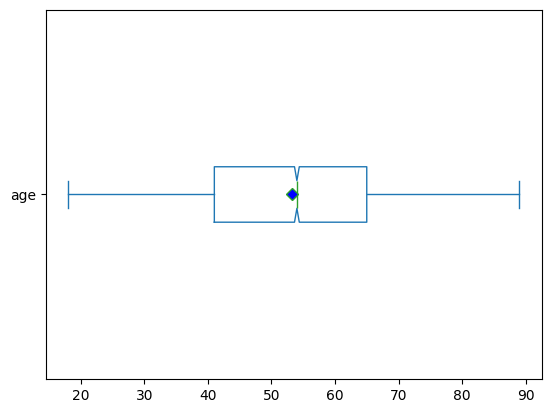

count    10000.00
mean        53.29
std         18.04
min         18.00
25%         41.00
50%         54.00
75%         65.00
max         89.00
Name: age, dtype: float64
-------------------------------
The mode is: 54.0
____________________________________________
The Information Below is For: children


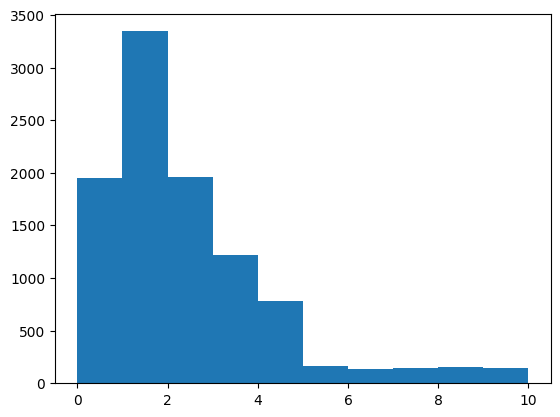

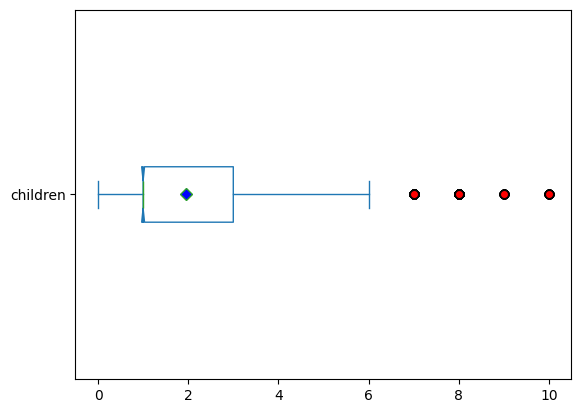

count    10000.000
mean         1.947
std          1.911
min          0.000
25%          1.000
50%          1.000
75%          3.000
max         10.000
Name: children, dtype: float64
-------------------------------
The mode is: 1.0
____________________________________________
The Information Below is For: income


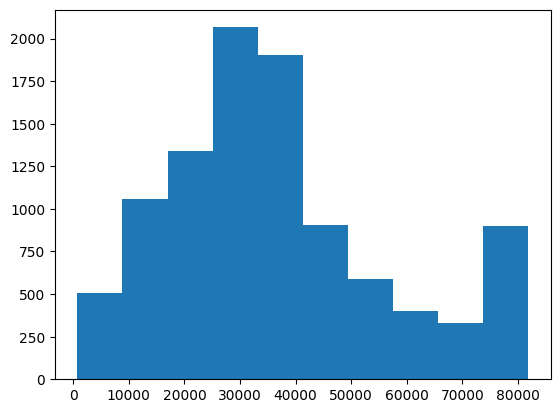

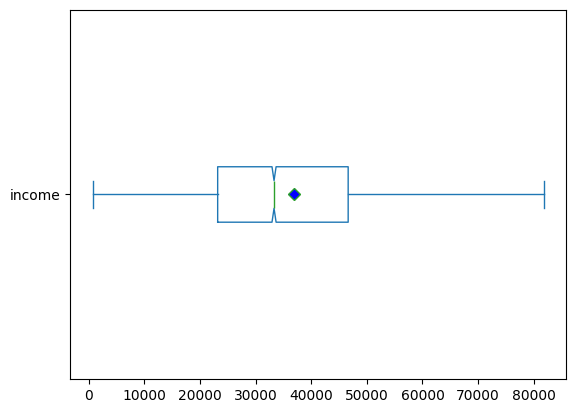

count    10000.000
mean     36875.336
std      20295.737
min        740.660
25%      23163.538
50%      33304.890
75%      46638.982
max      81852.150
Name: income, dtype: float64
-------------------------------
The mode is: 81852.15
____________________________________________
The Information Below is For: monthly_charge


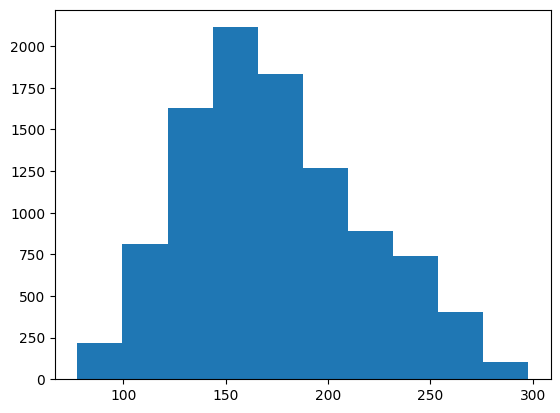

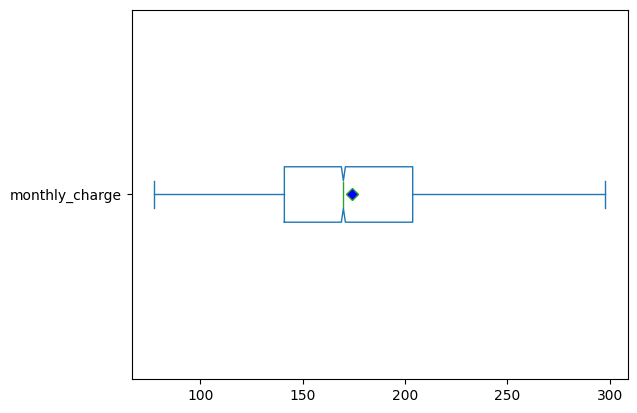

count    10000.000
mean       174.073
std         43.324
min         77.505
25%        141.071
50%        169.915
75%        203.777
max        297.837
Name: monthly_charge, dtype: float64
-------------------------------
The mode is: 297.8369855125
____________________________________________
The Information Below is For: bandwidth_gb_year


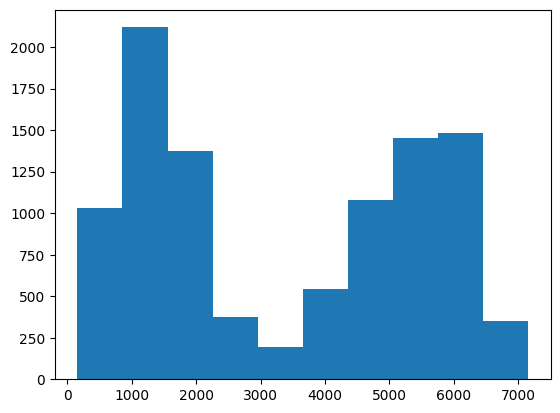

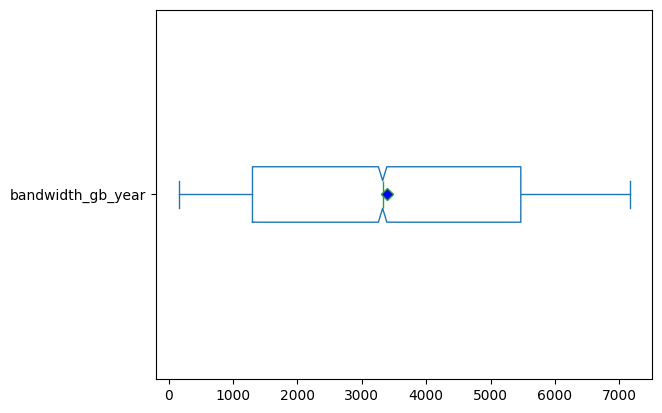

count    10000.000
mean      3387.142
std       2110.914
min        155.507
25%       1302.185
50%       3323.735
75%       5470.032
max       7158.982
Name: bandwidth_gb_year, dtype: float64
-------------------------------
The mode is: 4159.306
____________________________________________


In [22]:

univar(churn,'age')
univar(churn,'children')
univar(churn,'income')
univar(churn,'monthly_charge')
univar(churn,'bandwidth_gb_year')

In [23]:
#Create segments 
#Area
area_segment = churn.groupby(['area','churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Age Group
age_segment = churn.groupby(['age_group','churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Education
education_segment = churn.groupby(['education','churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Churn
churn_segment = churn.groupby(['churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Martial
marital_segment = churn.groupby(['marital','churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Integers & floats
churn_num = churn.select_dtypes(include = "number")


In [24]:
#Get Dummy Variables
area_dummy = pd.get_dummies(churn.area, prefix = 'area', drop_first = False)
age_group_dummy = pd.get_dummies(churn.age_group, prefix = 'age_group', drop_first = False)
education_dummy = pd.get_dummies(churn.education, prefix= 'education', drop_first = False)
martial_dummy = pd.get_dummies(churn.marital, prefix = 'marital', drop_first = False)

churn_dummy = churn.join([area_dummy, age_group_dummy, education_dummy, martial_dummy])

In [25]:
churn1 = churn.map(lambda x: 1 if x is True else 0 if x is False else x)

churn1.sample(random_state = 13)


,customer_id,state,area,children,age,education,employment,income,marital,gender,churn,outage_sec_perweek,yearly_equip_failure,contract,internet_service,tech_support,streaming_tv,streaming_movies,tenure,monthly_charge,bandwidth_gb_year,timely_response,timely_fixes,timely_replacements,reliability,options,respectful_responses,courteous_exchange,evidence_of_active_listening,age_group
5952,K780224,NM,Urban,4.0,58.0,Bachelor's Degree,Part Time,36343.28,Never Married,Male,0,11.04075,0,Two Year,Fiber Optic,1.0,0,0,17.77264,117.1011,4910.179,3,4,5,2,5,2,2,2,50-59


In [26]:
churn.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000,10000,A00088,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,10000,52,TX,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area,10000,3,Suburban,3346,NaN,NaN,NaN,NaN,NaN,NaN,NaN
children,10000.0,NaN,NaN,NaN,1.94665,1.9106,0.0,1.0,1.0,3.0,10.0
age,10000.0,NaN,NaN,NaN,53.2899,18.040047,18.0,41.0,54.0,65.0,89.0
education,10000,12,Regular High School Diploma,2421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment,10000,5,Full Time,5992,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,10000.0,NaN,NaN,NaN,36875.336247,20295.736894,740.66,23163.5375,33304.89,46638.9825,81852.15
marital,10000,5,Divorced,2092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10000,3,Female,5025,NaN,NaN,NaN,NaN,NaN,NaN,NaN


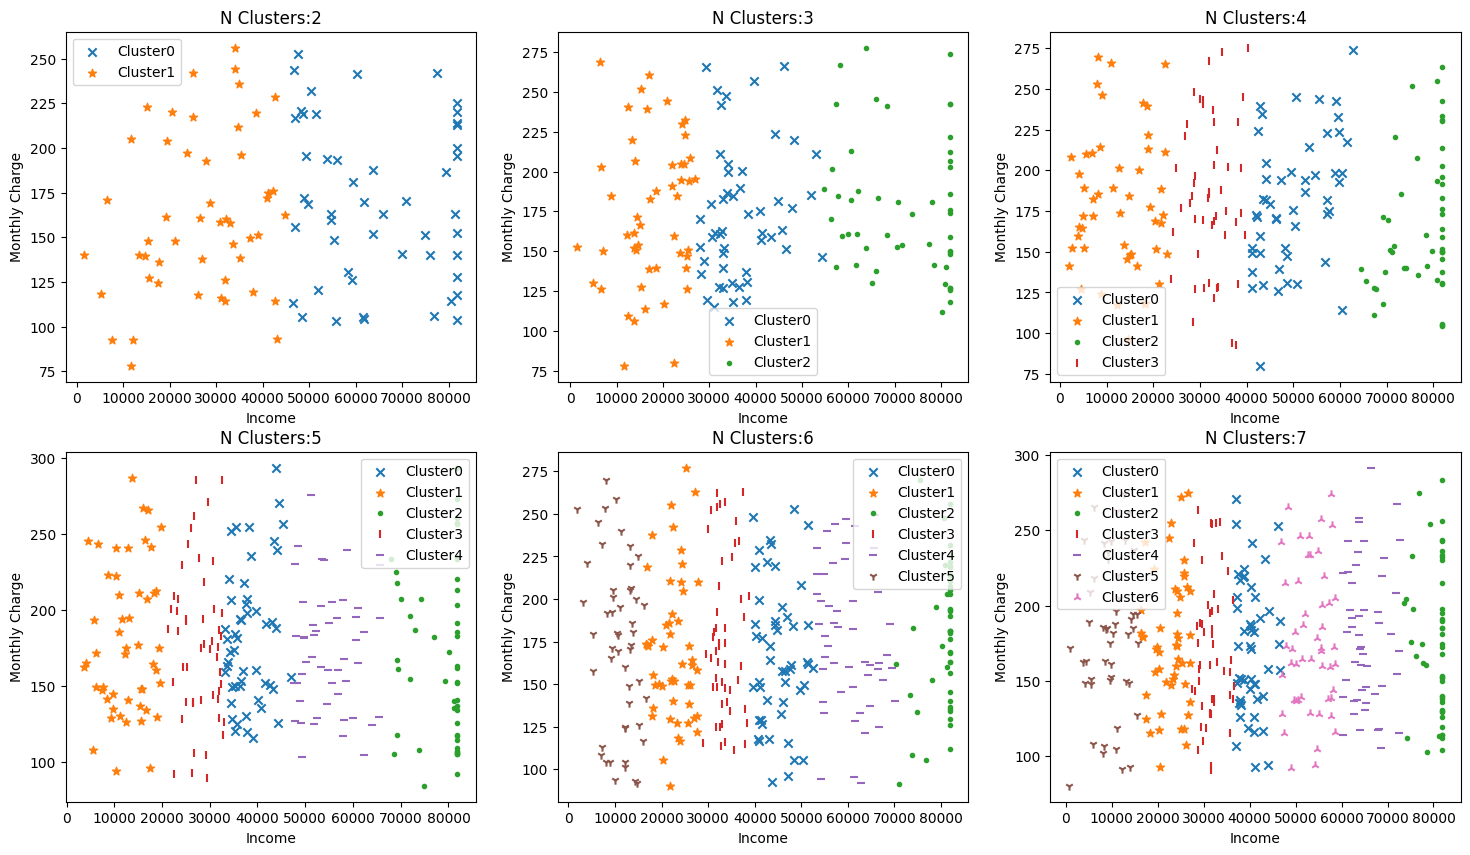

In [27]:
from sklearn.cluster import KMeans

cluster_cols = ['income', 'monthly_charge']
markers = ['x', '*', '.', '|', '_', '1', '2']

plt.figure(figsize = [18,10])


for n in range(2,8):
    model = KMeans(n_clusters = n,
                   random_state = 13)
    churn['Cluster_income'] = model.fit_predict(churn[cluster_cols])
    plt.subplot(2, 3, n-1)
    for clust in range(n):
        temp = churn[churn.Cluster_income == clust]
        plt.scatter(temp.income.sample(50, random_state=13),
                    temp.monthly_charge.sample(50, random_state=13),
                    marker = markers[clust],
                    label = 'Cluster' +str(clust))
        plt.title('N Clusters:' + str(n))
        plt.xlabel('Income')
        plt.ylabel('Monthly Charge')
        plt.legend()

plt.show()

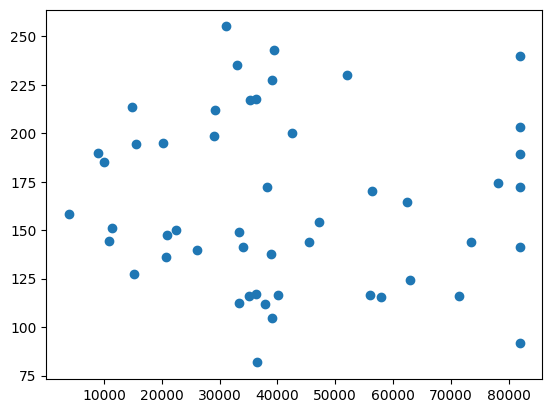

In [28]:
plt.scatter(churn.income.sample(50, random_state=13),
            churn.monthly_charge.sample(50, random_state=13))